In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.ETD_KT_CM_JAX_Vectorised import *
from filters import resamplers
from filters.filter import ParticleFilter
from filters.filter import ParticleFilterAll
jax.config.update("jax_enable_x64", True)
import numpy as np

Initialisation of a twin experiment. 

In [3]:
signal_params = ConfigDict(KS_params_SALT)
ensemble_params = ConfigDict(KS_params_SALT)
ensemble_params.update(E=1,P=32,stochastic_advection_basis='constant')
ensemble_params.update(E=128,P=32,stochastic_advection_basis='constant')

Now we specify the models, by calling the class.

In [4]:
signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
ensemble_model = ETD_KT_CM_JAX_Vectorised(ensemble_params)

initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
initial_ensemble = initial_condition(ensemble_model.x, ensemble_params.E, ensemble_params.initial_condition)

print(ensemble_model.params,ensemble_model.nt)
available_resamplers = ", ".join(resamplers.keys())
print(available_resamplers)

I0000 00:00:1742903844.249679       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


Advection_basis_name: sin
E: 128
Forcing_basis_name: none
P: 32
S: 0
c_0: 0
c_1: 1
c_2: 1
c_3: 0.0
c_4: 1
dt: 0.25
equation_name: Kuramoto-Sivashinsky
initial_condition: Kassam_Trefethen_KS_IC
method: Dealiased_SETDRK4
noise_magnitude: 0.001
nx: 256
stochastic_advection_basis: constant
tmax: 150
xmax: 100.53096491487338
xmin: 0
 600
multinomial, systematic, no_resampling, default


In [5]:
observation_spatial_frequency = 16
observation_locations = np.arange(0,signal_model.x.shape[0],observation_spatial_frequency)
observation_noise = 0.1
number_of_observations_time = 8#ensemble_model.nt
observation_temporal_frequency = int(ensemble_model.nt/number_of_observations_time)
print(f"Observation temporal frequency: {observation_temporal_frequency}")
print(observation_locations)
pf_systematic = ParticleFilterAll(
    n_particles = ensemble_params.E,
    n_steps = observation_temporal_frequency,
    n_dim = initial_signal.shape[-1],
    forward_model = ensemble_model,
    signal_model = signal_model,
    sigma = observation_noise,
    seed = 11,
    resampling="systematic",#'default',
    observation_locations = observation_locations,
)

Observation temporal frequency: 75
[  0  16  32  48  64  80  96 112 128 144 160 176 192 208 224 240]


To run the filter with all outputs, the input arrays need to have 3 dimensions.
They are (time, n_particles, space).

In [6]:
da_steps = number_of_observations_time
print(initial_ensemble.shape, initial_signal.shape, da_steps)
initial_ensemble = initial_ensemble[None, ...] # adding the time dimension
initial_signal = initial_signal[None, ...] # adding the time dimension
final, all = pf_systematic.run(initial_ensemble, initial_signal, da_steps) #the final input is scan length? 

(128, 256) (1, 256) 8


In [7]:
print(len(final), len(all))

2 3


The two outputs are tuples. The first tuple has length 2 and contains the final ensemble and the final signal arrays.
The second tuple has length three and contains all outputs through time of the ensemble, signal and observation.

(8, 75, 128, 256)
(8, 75, 1, 256)
(8, 1, 256)
(600, 128, 256)


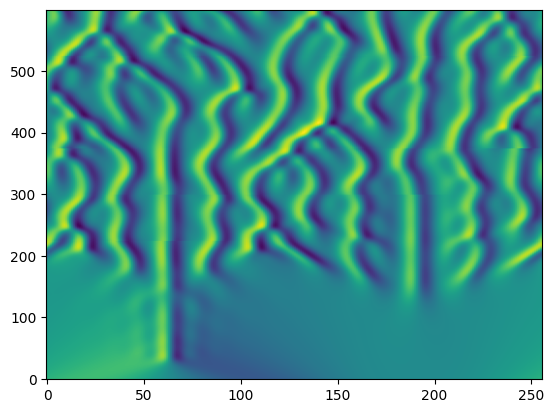

In [8]:
for i in range(3):
    print(all[i].shape)
arr = all[0]
all_0_reshaped = jnp.reshape(arr, (-1, arr.shape[2], arr.shape[3]))
print(all_0_reshaped.shape)
plt.imshow(all_0_reshaped[:,0,:], aspect='auto', origin='lower')
plt.show()


In [9]:
for i in range(2):
    print(final[i].shape)

(1, 128, 256)
(1, 1, 256)


Put in the initial condition.

In [10]:
print(initial_ensemble.shape)
particles =jnp.concatenate([initial_ensemble[None,None,...], all[0]], axis=0)
print(particles.shape)
signal = jnp.concatenate([initial_signal[None,None,...], all[1]], axis=0)
observations = jnp.concatenate([initial_signal[None,...], all[2]], axis=0)
observations = all[2][:,:, observation_locations]
print(observations.shape)


(1, 128, 256)


TypeError: Cannot concatenate arrays with different numbers of dimensions: got (1, 1, 1, 128, 256), (8, 75, 128, 256).

In [ ]:
def plot(da_step):
    plt.plot(signal_model.x, signal[da_step,0,0,:], color='k',label='signal')
    plt.plot(signal_model.x, particles[da_step,0,:,:].T, color='b',label='particles',linewidth=0.1)
    if da_step > 0:
        plt.plot(signal_model.x[observation_locations], observations[da_step-1,0,:], 'ro',label='observations')
    plt.show()

interact(plot, da_step=(0, da_steps))

interactive(children=(IntSlider(value=300, description='da_step', max=600), Output()), _dom_classes=('widget-i…

<function __main__.plot(da_step)>